In [1]:
### PREREQUISTIES
### (many used only in one notebook...)

import os
import pandas as pd
import numpy as np
import logging ### to monitor the code
from bs4 import BeautifulSoup
import pickle
import math
import random
import sys
import csv
import unicodedata
import requests
import re
import json

import nltk
from nltk.collocations import *

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

import xml.etree.cElementTree as ET
from urllib.request import urlopen

import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
#from google.colab import auth
#from oauth2client.client import GoogleCredentials
from google.oauth2 import service_account # based on google-auth library
import sddk

In [2]:
publicfolder = "8fe7d59de1eafe5f8eaebc0044534606"
morpheus_by_lemma = json.loads(requests.get("https://sciencedata.dk/public/" + publicfolder + "/morpheus_by_lemma.json").content)

In [3]:
#!pip install anda
#from anda import gr ### the import takes substantial time, since it import a +600MB file containing ancient Greek dictionary

In [4]:
### not neccessary for reading the data, just for exporting them to sciencedata.dk
conf = sddk.configure()

sciencedata.dk username (format '123456@au.dk'): 648597@au.dk
sciencedata.dk password: ········
endpoint variable has been configured to: https://sciencedata.dk/files/


In [5]:
# to access gsheet, you need Google Service Account key json file
# I have mine located in my personal space on sciencedata.dk, so I read it from there:

# (1) read the file and parse its content
file_data = conf[0].get(conf[1] + "ServiceAccountsKey.json").json()
# (2) transform the content into crendentials object
credentials = service_account.Credentials.from_service_account_info(file_data)
# (3) specify your usage of the credentials
scoped_credentials = credentials.with_scopes(['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive'])
# (4) use the constrained credentials for authentication of gspread package
gc = gspread.Client(auth=scoped_credentials)
# (5) establish connection with spreadsheets specified by their url
PIA_data = gc.open_by_url("https://docs.google.com/spreadsheets/d/1KxOx7Be9fj3lDcEPgQhQ-Iqcn9p367-MMD6RMXe8rks/edit?usp=sharing")
PIA_overview = gc.open_by_url("https://docs.google.com/spreadsheets/d/1e94wyelg6dftQ4zxbq1xvwxWAI-BhcYXtclDW-YTnrw/edit?usp=sharing")

In [6]:
publicfolder = "31b393e2afe1ee96ce81869c7efe18cb"
c_hippocraticum = sddk.read_file("c_hippocraticum_enriched.json", "df", publicfolder)

reading file located in a public folder


In [7]:
c_hippocraticum.columns

Index(['filename', 'author', 'title', 'wordcount', 'author_id', 'doc_id',
       'raw_date', 'date_avr', 'date_probs', 'date_manual', 'provenience',
       'tlg_epithet', 'clean_string', 'n_sentences', 'lemmatized_sentences',
       'lemmata', 'lemmata_wordcount', 'lemmata_repl',
       'lemmatized_sentences_repl', 'λύπ*', 'ἄλγ*', 'ὀδύν*', 'πόνο*',
       'terms_sum', 'λύπ*_TF', 'ἄλγ*_TF', 'ὀδύν*_TF', 'πόνο*_TF', 'TF_sum',
       'work_cat_jouanna', 'work_cat_craik', 'work_cat_linka'],
      dtype='object')

In [8]:
# the viper is out!!!
c_hippocraticum["lemmata_repl"].apply(lambda x: x.count("ἔχις")).sum()

0

In [9]:
key_words = ['λύπ*', 'ἄλγ*', 'ὀδύν*', 'πόνο*']

In [10]:
def sentences_with_term(sentences, term, flatlist=False):
    sentences_with_term = [sen for sen in sentences if term in sen]
    if flatlist == True:
        flatlist = [word for sen in sentences_with_term for word in sen]
        return flatlist
    else: 
        return sentences_with_term

In [11]:
for word in key_words:
    c_hippocraticum[word + "_sents"] = c_hippocraticum["lemmatized_sentences_repl"].apply(lambda x: sentences_with_term(x, word, True))

In [12]:
for word in key_words:
    c_hippocraticum[word + "_sents"] = c_hippocraticum[word + "_sents"].apply(lambda sentences:  [word for word in sentences if word not in ["ἢν", "ὁκόταν"]])

In [13]:
all_sents = [sent for doc_sents in c_hippocraticum["lemmatized_sentences_repl"].tolist() for sent in doc_sents]
len(all_sents)

24456

In [14]:
print(all_sents[:3])

[['ὁπόσος', 'ἐπιχειρέω', 'ἰητρικῆς', 'λέγω', 'γράφω', 'ὑπόθεσις', 'αὐτός', 'ὑποθέμενοι', 'λόγος', 'θερμός', 'ψυχρός', 'ὑγρός', 'ξηρός', 'ἄλλος', 'ἐθέλω', 'βραχύς', 'ἄγω', 'ἀρχή', 'αἰτία', 'ἄνθρωπος', 'νοῦσος', 'θάνατος', 'πᾶς', 'αὐτός', 'εἷς', 'ὑποθέμενοι', 'πολύς', 'λέγω', 'καταφανής', 'εἰμί', 'ἁμαρτάνω', 'ἄξιος', 'μέμφομαι', 'τέχνη', 'εἰμί', 'χράω', 'πᾶς', 'μέγας', 'τιμάω', 'ἀγαθός', 'χειροτέχνης', 'δημιουργός'], ['δημιουργός', 'φαῦλος', 'πολύς', 'διαφέροντες'], ['εἰμί', 'ἰατρικός', 'αὐτός', 'ἔσκεπτο', 'εὑρίσκω', 'μηδείς', 'εἰμί', 'πᾶς', 'ἄπειρος', 'ἀνεπιστήμων', 'εἰμί', 'τύχη', 'κάμνω', 'διοικεῖτο']]


In [15]:
wordlists = {}
for word in key_words:
    corpus_wordlist = []
    for wordlist in c_hippocraticum[word + "_sents"]:
        corpus_wordlist.extend(wordlist)
    wordlists[word] = corpus_wordlist

In [16]:
wordlists_freqs = {}
for word in key_words:
    word_counts = nltk.FreqDist(wordlists[word]).most_common(21)
    word_count = c_hippocraticum[word + "_sents"].apply(lambda x: len(x)).sum()
    word_freqs = [(tup[0], np.round(tup[1] / word_count, 5)) for tup in word_counts]
    wordlists_freqs[word + " word"] = [tup[0] for tup in word_counts]
wordlists_freqs_df = pd.DataFrame(wordlists_freqs)
wordlists_freqs_df

,λύπ* word,ἄλγ* word,ὀδύν* word,πόνο* word
0,λύπ*,ἄλγ*,ὀδύν*,πόνο*
1,εἰμί,εἰμί,ἔχω,γίγνομαι
2,γίγνομαι,πυρετός,γίγνομαι,πολύς
3,ἄνθρωπος,κεφαλή,εἰμί,εἰμί
4,σῶμα,γίγνομαι,πυρετός,σῶμα
5,αὐτός,ἔχω,πολύς,ἔχω
6,οὗτος,ὀδύν*,κεφαλή,οὗτος
7,πολύς,κοιλία,γαστήρ,ἄλλος
8,κοιλία,οὗτος,οὗτος,κοιλία
9,οὐδείς,γαστήρ,ἴσχω,πυρετός


In [17]:
unique_words = []
for col in wordlists_freqs_df.columns:
    unique_words.extend(wordlists_freqs_df[col].tolist())
unique_words = list(set(unique_words))

In [18]:
wordlists_freqs = {}
for word in key_words:
    word_counts = nltk.FreqDist(wordlists[word]).most_common(21)
    c_hippocraticum[word + "_sents"]
    word_count = c_hippocraticum[word + "_sents"].apply(lambda x: len(x)).sum()
    word_freqs = [(tup[0], np.round(tup[1] / word_count, 5)) for tup in word_counts]
    wordlists_freqs[word + " (n={0})".format(word_counts[0][1]) ] = word_freqs[1:]
wordlists_freqs_df = pd.DataFrame(wordlists_freqs)
wordlists_freqs_df

,λύπ* (n=58),ἄλγ* (n=315),ὀδύν* (n=645),πόνο* (n=657)
0,"(εἰμί, 0.03714)","(εἰμί, 0.01698)","(ἔχω, 0.02284)","(γίγνομαι, 0.02052)"
1,"(γίγνομαι, 0.02122)","(πυρετός, 0.01644)","(γίγνομαι, 0.02245)","(πολύς, 0.0179)"
2,"(ἄνθρωπος, 0.01592)","(κεφαλή, 0.01644)","(εἰμί, 0.01527)","(εἰμί, 0.01615)"
3,"(σῶμα, 0.01592)","(γίγνομαι, 0.01644)","(πυρετός, 0.01411)","(σῶμα, 0.01514)"
4,"(αὐτός, 0.01592)","(ἔχω, 0.01617)","(πολύς, 0.01334)","(ἔχω, 0.01092)"
5,"(οὗτος, 0.01459)","(ὀδύν*, 0.0124)","(κεφαλή, 0.01142)","(οὗτος, 0.01004)"
6,"(πολύς, 0.01459)","(κοιλία, 0.01105)","(γαστήρ, 0.01026)","(ἄλλος, 0.0099)"
7,"(κοιλία, 0.00928)","(οὗτος, 0.01024)","(οὗτος, 0.00885)","(κοιλία, 0.00844)"
8,"(οὐδείς, 0.00796)","(γαστήρ, 0.00943)","(ἴσχω, 0.00795)","(πυρετός, 0.00844)"
9,"(ἡμέρα, 0.00796)","(ὀσφῦς, 0.00916)","(παρέχω, 0.00693)","(πᾶς, 0.00742)"


In [19]:
#set_with_dataframe(PIA_overview.add_worksheet("tfs-in-sentences", 1, 1), wordlists_freqs_df)

In [20]:
wordlists_freqs = {}
for word in key_words:
    word_counts = nltk.FreqDist(wordlists[word]).most_common(21)
    c_hippocraticum[word + "_sents"]
    word_count = c_hippocraticum[word + "_sents"].apply(lambda x: len(x)).sum()
    tfs = [np.round(tup[1] / word_count, 5) for tup in word_counts]
    tf_words = [tup[0] for tup in word_counts]
    wordlists_freqs[word + " words"] = tf_words[1:]
    wordlists_freqs[word + " TFs"] = tfs[1:]
wordlists_freqs_df = pd.DataFrame(wordlists_freqs)
wordlists_freqs_df

,λύπ* words,λύπ* TFs,ἄλγ* words,ἄλγ* TFs,ὀδύν* words,ὀδύν* TFs,πόνο* words,πόνο* TFs
0,εἰμί,0.03714,εἰμί,0.01698,ἔχω,0.02284,γίγνομαι,0.02052
1,γίγνομαι,0.02122,πυρετός,0.01644,γίγνομαι,0.02245,πολύς,0.01790
2,ἄνθρωπος,0.01592,κεφαλή,0.01644,εἰμί,0.01527,εἰμί,0.01615
3,σῶμα,0.01592,γίγνομαι,0.01644,πυρετός,0.01411,σῶμα,0.01514
4,αὐτός,0.01592,ἔχω,0.01617,πολύς,0.01334,ἔχω,0.01092
5,οὗτος,0.01459,ὀδύν*,0.01240,κεφαλή,0.01142,οὗτος,0.01004
6,πολύς,0.01459,κοιλία,0.01105,γαστήρ,0.01026,ἄλλος,0.00990
7,κοιλία,0.00928,οὗτος,0.01024,οὗτος,0.00885,κοιλία,0.00844
8,οὐδείς,0.00796,γαστήρ,0.00943,ἴσχω,0.00795,πυρετός,0.00844
9,ἡμέρα,0.00796,ὀσφῦς,0.00916,παρέχω,0.00693,πᾶς,0.00742


In [22]:
most_common = []
for word in key_words:
    wordlist = wordlists_freqs_df[word + " words"].tolist()
    most_common.extend(wordlist)
most_common_unique = list(set(most_common))
most_common_unique_df = pd.DataFrame(most_common_unique)

In [23]:
terms_by_cat_df = get_as_dataframe(PIA_overview.worksheet("terms_by_cat"))
terms_by_cat_dict = dict(zip(terms_by_cat_df["term"], terms_by_cat_df["term_category"]))
terms_by_cat_dict

{'πρότερος': 'temporal quality',
 'ψυχρός': 'quality',
 'λαμβάνω': 'verb',
 'κεφαλή': 'bodily parts and constituents',
 'ἰσχυρός': 'quality',
 'ἄνθρωπος': 'bodily parts and constituents',
 'χολή': 'bodily parts and constituents',
 'ὁπόσος': 'quality',
 'ἄλγ*': 'pain-word',
 'τρίτος': 'temporal quality',
 'πᾶς': 'quality',
 'πλείων': 'quality',
 'σάρξ': 'bodily parts and constituents',
 'συμβαίνω': 'verb',
 'θερμός': 'quality',
 'μαλλός': 'quality',
 'ἡμέρα': 'temporal quality',
 'πόνο*': 'pain-word',
 'ὀδύν*': 'pain-word',
 'κοιλία': 'bodily parts and constituents',
 'εἶμι': 'verb',
 'ποιέω': 'verb',
 'γίγνομαι': 'verb',
 'ἔχω': 'verb',
 'καθίημι': 'verb',
 'δοκέω': 'verb',
 'δίδωμι': 'verb',
 'ὀξύς': 'quality',
 'πολύς': 'quality',
 'μήτρα': 'bodily parts and constituents',
 'ἰξύς': 'bodily parts and constituents',
 'κενεών': 'bodily parts and constituents',
 'χρόνος': 'temporal quality',
 'σιτίον': 'pathological state',
 'ἴσχω': 'verb',
 'ἐσθίω': 'verb',
 'νόσος': 'pathological state

In [24]:
[word for word in unique_words if word not in terms_by_cat_dict.keys()] 

[]

In [25]:
#words_for_coding = [word for word in unique_words if word not in terms_by_cat_dict.keys()]
#set_with_dataframe(PIA_overview.add_worksheet("words_for_coding_20201202", 1, 1), pd.DataFrame(words_for_coding))

In [26]:
# https://matplotlib.org/3.1.0/gallery/color/named_colors.html
import matplotlib.colors as mcolors
colors_list = list(mcolors.TABLEAU_COLORS.keys()) + list(mcolors.BASE_COLORS.keys())
print(colors_list)

['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']


In [27]:
# remove white
colors_list = [col for col in colors_list if col not in ["b", "w"]] 

In [28]:
term_cats = list(set(terms_by_cat_dict.values()))
print(term_cats)

['pain-word', 'pathological state', 'adj', 'bodily parts and constituents', 'temporal quality', 'quality', 'verb']


In [40]:
colors = ["green", "red", "lightgray", "orange", "gray", "gray","gray"]
cat_colors_dict = dict(zip(term_cats, colors))
cat_colors_dict

{'pain-word': 'green',
 'pathological state': 'red',
 'adj': 'lightgray',
 'bodily parts and constituents': 'orange',
 'temporal quality': 'gray',
 'quality': 'gray',
 'verb': 'gray'}

In [41]:
cat_colors_dict["bodily parts and constituents"] #terms_by_col_dict[key]]

'orange'

In [42]:
cat_colors_dict[terms_by_cat_dict["γίγνομαι"]]

'gray'

In [43]:
terms_by_col_dict = {}
for key in terms_by_cat_dict.keys():
    #print(key)
    terms_by_col_dict[key] = cat_colors_dict[terms_by_cat_dict[key]]

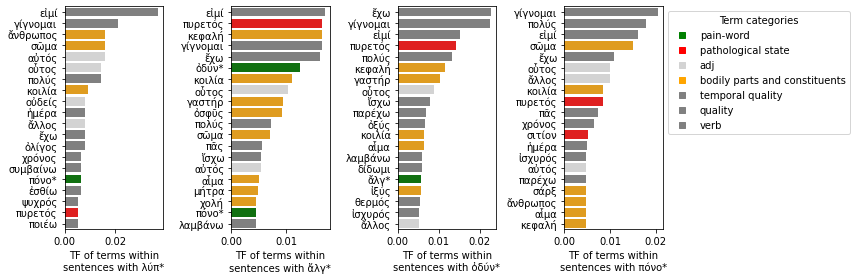

In [44]:
#plt.rcParams['figure.figsize'] = [12, 4]
fig, axs = plt.subplots(1, 4, figsize=[12,4], tight_layout=True)

for word, ax in zip(key_words, axs):
    xcol = wordlists_freqs_df[word + " TFs"]
    ycol = wordlists_freqs_df[word + " words"]
    actual_colors = [terms_by_col_dict[word] for word in ycol]
    sns.barplot(x=xcol, y=ycol, palette=actual_colors, ax=ax)
    ax.set(ylabel="", xlabel="TF of terms within\nsentences with " + word)

plt.subplots_adjust(hspace=0.08) # top=1, bottom=0, left=0, right=1, hspace=0.08, wspace=1.2)

#plt.title("Most frequent terms in sentences containing pain-words                       ", loc="right")

markers = [plt.Line2D([0,0],[0,0],color=color, marker="s", linestyle="") for color in colors]
plt.legend(markers, term_cats, numpoints=1,  title="Term categories", bbox_to_anchor=(1, 1), loc='upper left')

In [45]:
sddk.write_file("public_data/PIA/terms_in_sentences_20201207.png", fig, conf)

A file with the same name ("terms_in_sentences_20201207.png") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/public_data/PIA/terms_in_sentences_20201207.png"


https://sciencedata.dk/public/31b393e2afe1ee96ce81869c7efe18cb/terms_in_sentences_20201207.png

# TFIDF

In [46]:
def term_idf(term):
    idf_raw =  len(all_sents) / len([sent for sent in all_sents if term in sent])
    idf_log = math.log(idf_raw)
    return idf_log
#authors_df["dik_sents_TFIDF"] = authors_df.apply(lambda x: get_tfidf(x["dik_sents_flat"], x["lemmatized_sentences"]), axis=1)

In [47]:
pain_words_sents = {}
for col in [col for col in c_hippocraticum.columns if "*_sents" in col]:
    pain_words_sents[col.partition("_")[0] + "_all_sents"] = {}
    list_of_lists = c_hippocraticum[col].tolist()
    words = [word for doc in list_of_lists for word in doc if word != col.partition("_")[0]]
    word_counts = nltk.FreqDist(words).most_common()
    FD = [(tup[0] , np.round(tup[1]  / len(words), 5)) for tup in word_counts]
    TFIDF = [(tup[0], np.round(tup[1] * term_idf(tup[0]), 5)) for tup in FD]
    TFIDF = sorted(TFIDF, key=lambda tup: tup[1], reverse=True)    
    pain_words_sents[col.partition("_")[0] + "_all_sents"] = {"words" : words, "word_counts" : word_counts, "FD" : FD, "TFIDF": TFIDF}

In [48]:
pain_words_sents.keys()

dict_keys(['λύπ*_all_sents', 'ἄλγ*_all_sents', 'ὀδύν*_all_sents', 'πόνο*_all_sents'])

In [49]:
pain_words_sents["λύπ*_all_sents"]["FD"]

[('εἰμί', 0.04023),
 ('γίγνομαι', 0.02299),
 ('ἄνθρωπος', 0.01724),
 ('σῶμα', 0.01724),
 ('αὐτός', 0.01724),
 ('οὗτος', 0.0158),
 ('πολύς', 0.0158),
 ('κοιλία', 0.01006),
 ('οὐδείς', 0.00862),
 ('ἡμέρα', 0.00862),
 ('ἄλλος', 0.00862),
 ('ἔχω', 0.00862),
 ('ὀλίγος', 0.00862),
 ('χρόνος', 0.00718),
 ('συμβαίνω', 0.00718),
 ('πόνο*', 0.00718),
 ('ἐσθίω', 0.00718),
 ('ψυχρός', 0.00575),
 ('πυρετός', 0.00575),
 ('ποιέω', 0.00575),
 ('πρῶτος', 0.00431),
 ('πάρειμι', 0.00431),
 ('τρίτος', 0.00431),
 ('ἰσχυρός', 0.00431),
 ('χρή', 0.00431),
 ('τοιοῦτος', 0.00431),
 ('κεφαλή', 0.00431),
 ('λαμβάνω', 0.00431),
 ('ὀστέον', 0.00431),
 ('ψυχή', 0.00431),
 ('λέγω', 0.00431),
 ('προσήκω', 0.00431),
 ('ἕτερος', 0.00431),
 ('ἐξέρχομαι', 0.00431),
 ('χολή', 0.00431),
 ('πῦρ', 0.00431),
 ('ἰκμάς', 0.00431),
 ('τὶς', 0.00431),
 ('ὑγιής', 0.00431),
 ('πᾶς', 0.00431),
 ('πίνω', 0.00431),
 ('χροιά', 0.00431),
 ('μήτρα', 0.00431),
 ('πρόσωπον', 0.00431),
 ('γονή', 0.00431),
 ('δεῖ', 0.00431),
 ('μεμιγμένα', 0

In [50]:
tfidf_lists = []
for key in pain_words_sents.keys():
    tfidf_lists.append(pain_words_sents[key]["TFIDF"][:20])

In [51]:
tfidf_20_df = pd.DataFrame(tfidf_lists).T#  
tfidf_20_df.columns=pain_words_sents.keys()
tfidf_20_df

,λύπ*_all_sents,ἄλγ*_all_sents,ὀδύν*_all_sents,πόνο*_all_sents
0,"(εἰμί, 0.0804)","(κεφαλή, 0.0629)","(ἔχω, 0.06531)","(σῶμα, 0.0509)"
1,"(ἄνθρωπος, 0.06375)","(πυρετός, 0.06213)","(πυρετός, 0.05324)","(γίγνομαι, 0.04894)"
2,"(αὐτός, 0.05494)","(ὀσφῦς, 0.05419)","(γίγνομαι, 0.0528)","(πολύς, 0.04855)"
3,"(σῶμα, 0.05242)","(ὀδύν*, 0.05028)","(γαστήρ, 0.04895)","(εἰμί, 0.03569)"
4,"(γίγνομαι, 0.04959)","(ἔχω, 0.04635)","(κεφαλή, 0.0436)","(ἄλλος, 0.03276)"
5,"(συμβαίνω, 0.04236)","(γαστήρ, 0.0451)","(ἴσχω, 0.04171)","(πυρετός, 0.03228)"
6,"(πολύς, 0.03877)","(κοιλία, 0.04028)","(ἰξύς, 0.03739)","(ἔχω, 0.03166)"
7,"(οὐδείς, 0.03875)","(γίγνομαι, 0.03874)","(παρέχω, 0.03574)","(κοιλία, 0.03114)"
8,"(οὗτος, 0.037)","(εἰμί, 0.03707)","(πολύς, 0.0357)","(πᾶς, 0.02696)"
9,"(ἐσθίω, 0.03409)","(ἴσχω, 0.02834)","(κενεών, 0.03375)","(χρόνος, 0.02619)"


In [56]:
#set_with_dataframe(PIA_overview.add_worksheet("tfidf_20_df", 1, 1), tfidf_20_df)

In [57]:
column = "λύπ*_all_sents"
tfidf_words = list(set([word for wordlist in [[tup[0] for tup in tfidf_20_df[column].tolist()] for column in tfidf_20_df.columns] for word in wordlist]))

In [58]:
[word for word in tfidf_words if word not in terms_by_cat_dict.keys()] 

[]

In [59]:
words_to_code = [word for word in tfidf_words if word not in terms_by_cat_dict.keys()] 
for word in words_to_code:
    try:
        print(word, morpheus_by_lemma[word])
    except:
        print(word)
    
    


In [62]:
df_columns = []
tfidf_20_split = []
for column in tfidf_20_df.columns:
    tfidf_20_split.append([tup[0] for tup in tfidf_20_df[column].tolist()])
    tfidf_20_split.append([tup[1] for tup in tfidf_20_df[column].tolist()])
    df_columns.extend([column.partition("_")[0] + "_words", column.partition("_")[0] + "_TFIDFs"])

In [63]:
tfidf_20_split_df = pd.DataFrame(tfidf_20_split).T
tfidf_20_split_df.columns = df_columns
tfidf_20_split_df

,λύπ*_words,λύπ*_TFIDFs,ἄλγ*_words,ἄλγ*_TFIDFs,ὀδύν*_words,ὀδύν*_TFIDFs,πόνο*_words,πόνο*_TFIDFs
0,εἰμί,0.0804,κεφαλή,0.0629,ἔχω,0.06531,σῶμα,0.0509
1,ἄνθρωπος,0.06375,πυρετός,0.06213,πυρετός,0.05324,γίγνομαι,0.04894
2,αὐτός,0.05494,ὀσφῦς,0.05419,γίγνομαι,0.0528,πολύς,0.04855
3,σῶμα,0.05242,ὀδύν*,0.05028,γαστήρ,0.04895,εἰμί,0.03569
4,γίγνομαι,0.04959,ἔχω,0.04635,κεφαλή,0.0436,ἄλλος,0.03276
5,συμβαίνω,0.04236,γαστήρ,0.0451,ἴσχω,0.04171,πυρετός,0.03228
6,πολύς,0.03877,κοιλία,0.04028,ἰξύς,0.03739,ἔχω,0.03166
7,οὐδείς,0.03875,γίγνομαι,0.03874,παρέχω,0.03574,κοιλία,0.03114
8,οὗτος,0.037,εἰμί,0.03707,πολύς,0.0357,πᾶς,0.02696
9,ἐσθίω,0.03409,ἴσχω,0.02834,κενεών,0.03375,χρόνος,0.02619


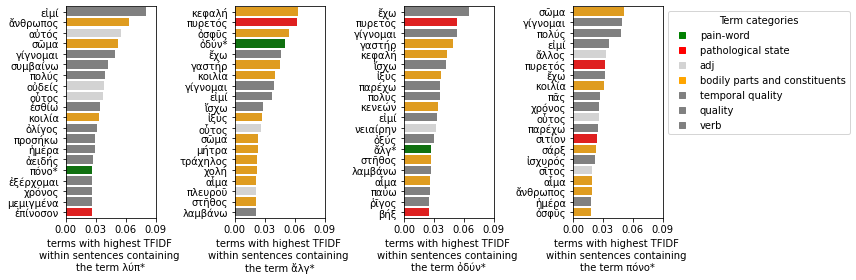

In [77]:
#plt.rcParams['figure.figsize'] = [12, 4]
fig, axs = plt.subplots(1, 4, figsize=[12,4], tight_layout=True)

for word, ax in zip(key_words, axs):
    xcol = tfidf_20_split_df[word + "_TFIDFs"]
    ycol = tfidf_20_split_df[word + "_words"]
    actual_colors = [terms_by_col_dict[word] for word in ycol]
    sns.barplot(x=xcol, y=ycol, palette=actual_colors, ax=ax)
    ax.set(ylabel="", xlabel="terms with highest TFIDF \nwithin sentences containing \nthe term " + word)
    ax.set_xticks([0, 0.03, 0.06, 0.09])
    ax.set_xlim(0, 0.09)
plt.subplots_adjust(hspace=0.08) # top=1, bottom=0, left=0, right=1, hspace=0.08, wspace=1.2)

#plt.title("Most frequent terms in sentences containing pain-words                       ", loc="right")

markers = [plt.Line2D([0,0],[0,0],color=color, marker="s", linestyle="") for color in colors]
plt.legend(markers, term_cats, numpoints=1,  title="Term categories", bbox_to_anchor=(1, 1), loc='upper left')

In [78]:
sddk.write_file("public_data/PIA/tfidfs_in_sentences_20210106.png", fig, conf)

A file with the same name ("tfidfs_in_sentences_20210106.png") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/public_data/PIA/tfidfs_in_sentences_20210106.png"
